In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, Grid, DenseNetwork, set_seed
import os

from tensorflow.keras.optimizers import SGD, Adam

Main difference is testing star age learning

In [2]:
seed = 101
name = 'grid_22'
tracks = 'tracks_04b'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [3]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [81]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')

In [82]:
len(train)

7735733

In [83]:
t = Tracks(name=tracks)
t.set_data(train.sample(7735500, random_state=seed))

del train

In [84]:
t.get_data().head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,frac_age,effective_T,luminosity,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,initial_Zinit,gradient,log_star_age,log_radius
5933768,1,1.17,0.24,-0.2,1.5,0.381987,6180.6750,2.203866,4.280516,0.121770,0.004602,-0.536008,97.249210,0.008581,0.000138,0.219018,0.112780
334900,1,1.16,0.28,-0.3,1.7,0.996618,6587.1980,4.786881,4.050493,0.149323,0.003788,-0.607039,63.997060,0.006473,0.000463,0.490498,0.225884
7135268,2,1.18,0.28,-0.1,2.3,1.022719,6349.7030,4.278201,4.042870,0.184591,0.007162,-0.310150,65.216125,0.010205,0.000369,0.568727,0.233383
3251278,1,0.81,0.24,0.4,2.5,0.545067,4438.7354,0.223159,4.540280,0.201984,0.028536,0.311528,171.295750,0.033051,0.000317,1.309384,-0.096953
1224838,2,1.12,0.32,0.2,1.9,1.269763,5169.1978,3.214738,3.786232,0.309476,0.018507,0.182351,43.206272,0.018963,0.001241,0.760349,0.349985


In [85]:
len(t._data)

7735500

## Normalize

Let's choose the inputs and outputs and the normalise

In [86]:
x_cols = ['frac_age', 'initial_mass', 'initial_MLT', 'initial_Yinit', 'initial_Zinit']
y_cols = ['log_star_age', 'effective_T', 'log_radius', 'delta_nu_fit', 'star_feh']

In [87]:
factors, _df = t.normalize(loc='mean', scale='std', columns=x_cols+y_cols)

In [88]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.807264,0.414357
1,initial_mass,initial_mass_norm,0.997338,0.117963
2,initial_MLT,initial_MLT_norm,1.996954,0.337990
3,initial_Yinit,initial_Yinit_norm,0.279594,0.028033
4,initial_Zinit,initial_Zinit_norm,0.018303,0.010686
5,log_star_age,log_star_age_norm,0.727604,0.466882
6,effective_T,effective_T_norm,5569.763832,601.275379
7,log_radius,log_radius_norm,0.117955,0.146779
8,delta_nu_fit,delta_nu_fit_norm,99.854229,42.580915
9,star_feh,star_feh_norm,-0.021189,0.360914


Round the loc and scale to 3 dp

In [89]:
factors = round(factors, 3)

In [90]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.807,0.414
1,initial_mass,initial_mass_norm,0.997,0.118
2,initial_MLT,initial_MLT_norm,1.997,0.338
3,initial_Yinit,initial_Yinit_norm,0.280,0.028
4,initial_Zinit,initial_Zinit_norm,0.018,0.011
5,log_star_age,log_star_age_norm,0.728,0.467
6,effective_T,effective_T_norm,5569.764,601.275
7,log_radius,log_radius_norm,0.118,0.147
8,delta_nu_fit,delta_nu_fit_norm,99.854,42.581
9,star_feh,star_feh_norm,-0.021,0.361


In [91]:
factors, _df = t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols)
_df.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
5933768,-1.026600,1.466102,-1.470414,-1.428571,-0.856232,-1.089898,1.016026,-0.035513,-0.061173,-1.426616
334900,0.458014,1.381356,-0.878698,0.000000,-1.047931,-0.508570,1.692128,0.733903,-0.842088,-1.623377
7135268,0.521060,1.550847,0.896450,0.000000,-0.708640,-0.341055,1.297142,0.784916,-0.813458,-0.800970
3251278,-0.632689,-1.584746,1.488166,-1.428571,1.368259,1.244934,-1.881050,-1.462265,1.677785,0.921130
1224838,1.117784,1.042373,-0.286982,1.428571,0.087535,0.069269,-0.666195,1.578132,-1.330352,0.563298


In [92]:
del _df

In [93]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols, inplace=True)

In [94]:
t.norm_factors.to_csv(os.path.join(save_path, 'tracks_04b_norm.csv'), index=False)

In [95]:
train = t.get_data([f'{col}_norm' for col in x_cols+y_cols]+['gradient'])
train.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm,gradient
5933768,-1.026600,1.466102,-1.470414,-1.428571,-0.856232,-1.089898,1.016026,-0.035513,-0.061173,-1.426616,0.000138
334900,0.458014,1.381356,-0.878698,0.000000,-1.047931,-0.508570,1.692128,0.733903,-0.842088,-1.623377,0.000463
7135268,0.521060,1.550847,0.896450,0.000000,-0.708640,-0.341055,1.297142,0.784916,-0.813458,-0.800970,0.000369
3251278,-0.632689,-1.584746,1.488166,-1.428571,1.368259,1.244934,-1.881050,-1.462265,1.677785,0.921130,0.000317
1224838,1.117784,1.042373,-0.286982,1.428571,0.087535,0.069269,-0.666195,1.578132,-1.330352,0.563298,0.001241


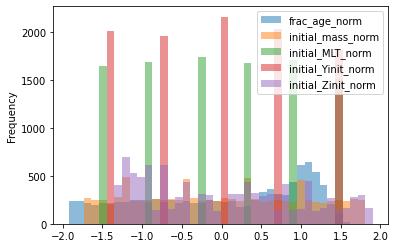

In [96]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in x_cols], bins=40, alpha=0.5)

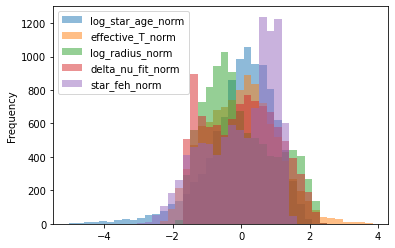

In [97]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in y_cols], bins=40, alpha=0.5)

Validation

In [98]:
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

In [99]:
t = Tracks()
t.set_data(val)

In [100]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
            columns=x_cols+y_cols, inplace=True)

In [101]:
val = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
val.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
0,-1.894701,0.025424,0.89645,-1.428571,-0.657099,-3.035447,0.324335,-1.197201,1.530781,-0.225741
1,-1.807178,0.025424,0.89645,-1.428571,-0.657099,-2.145522,0.337958,-1.169027,1.476221,-0.238075
2,-1.773367,0.025424,0.89645,-1.428571,-0.657099,-1.947024,0.343372,-1.159455,1.457834,-0.242870
3,-1.766615,0.025424,0.89645,-1.428571,-0.657099,-1.911994,0.344456,-1.157568,1.454220,-0.243819
4,-1.739636,0.025424,0.89645,-1.428571,-0.657099,-1.783885,0.348781,-1.150079,1.439909,-0.247589


In [102]:
del t

In [103]:
x_cols = [f'{col}_norm' for col in x_cols]
y_cols = [f'{col}_norm' for col in y_cols]

In [104]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 7735500
Length of validation data = 1933933


In [105]:
n_batches = np.arange(500, 2000)  # Select a range where number of batches is reasonable
r = (len(train)) % n_batches 

# Print whole multiples of training size
print(f'choose number of batches from:\n{n_batches[r==0]}')

choose number of batches from:
[ 500  540  573  675  750  764  810  900  955 1125 1146 1350 1500 1620
 1719 1910]


In [106]:
len(train)//764

10125

In [107]:
depth = [6]
width = [256]
activation = ['elu']
batch_size = [len(train)//764]
regularization_l2 = [1e-8]
optimizer = [SGD(0.001, 0.999)]
loss = ['mae', 'mse']
metrics = ['mae', 'mse']

In [108]:
def get_config(self):
    config = dict(
        name=self.name,
        model_filename=self.model_filename,
        history_filename=self.history_filename,
        optimizer=str(self.optimizer),
        loss=self.loss,
        metrics=self.metrics,
        x_cols=self.x_cols,
        y_cols=self.y_cols
        )
    return config

In [109]:
DenseNetwork.get_config = get_config

In [110]:
def compile_all(self, loss='mae', metrics=None, **kwargs):
    '''Compile all neural networks on the grid. '''
    self.networks.apply(lambda network: network.compile(
        optimizer=grid.data.loc[grid.data.index==network.name, 'optimizer'].values[0], 
        loss=grid.data.loc[grid.data.index==network.name, 'loss'].values[0], 
        metrics=metrics, **kwargs))

Grid.compile_all = compile_all

In [111]:
grid = Grid(path=save_path, name=name, depth=depth, width=width,
                        activation=activation, batch_size=batch_size,
                        regularization_l2=regularization_l2, optimizer=optimizer, loss=loss)

grid.data

,depth,width,activation,batch_size,regularization_l2,optimizer,loss
name,,,,,,,
grid_22_0,6,256,elu,10125,1.000000e-08,<tensorflow.python.keras.optimizer_v2.gradient...,mae
grid_22_1,6,256,elu,10125,1.000000e-08,<tensorflow.python.keras.optimizer_v2.gradient...,mse


In [117]:
grid.make_networks(DenseNetwork, 
                   param_columns=['depth', 'width', 'activation', 'batch_size', 'regularization_l2'])

In [118]:
grid.build_all(len(x_cols), len(y_cols))

In [119]:
grid.compile_all(metrics=metrics)

In [120]:
fit_kw = {'sample_weight': train['gradient'].to_numpy()}

In [123]:
grid.train_all(train, x_cols, y_cols, epochs=500, validation_data=val, validation_split=None,
               callbacks=['tensorboard'], fit_kw=fit_kw)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [127]:
network.history

,epochs,loss,mae,mse,val_loss,val_mae,val_mse
0,0,0.000417,0.740638,0.820538,0.509432,0.579229,0.509420
1,1,0.000152,0.452710,0.328258,0.242841,0.385117,0.242828
2,2,0.000121,0.366750,0.218425,0.190908,0.341518,0.190895
3,3,0.000095,0.317987,0.169758,0.160318,0.307279,0.160305
4,4,0.000087,0.314541,0.166120,0.172118,0.322528,0.172105
...,...,...,...,...,...,...,...
495,495,0.000021,0.078155,0.017388,0.017387,0.078084,0.017374
496,496,0.000021,0.078038,0.017348,0.017355,0.077981,0.017343
497,497,0.000021,0.077910,0.017306,0.017317,0.077868,0.017304
498,498,0.000021,0.077801,0.017273,0.017272,0.077735,0.017259


Add a function which plots history for all networks.

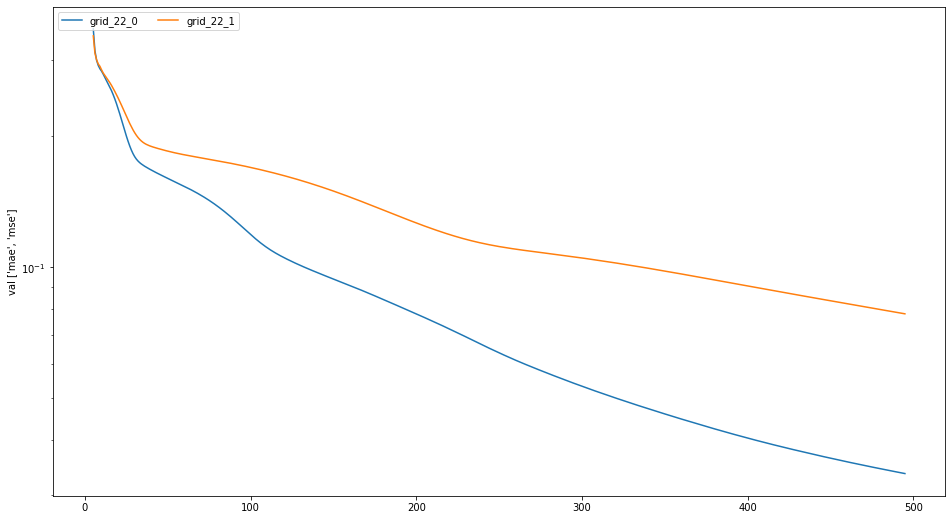

In [131]:
fig, ax = plt.subplots(figsize=(16, 9))
filter_width = 10  # filter width in epochs

for network in grid.networks:
#     network.history.plot(ax=ax, x='epochs', y=['val_loss'], logy=True, alpha=0.5,
#                          label=[f'{network.name} val loss'])
    df = network.history
    y = np.convolve(network.history.val_mae, np.ones((filter_width,))/filter_width, mode='valid')
    ax.plot(df.iloc[filter_width//2:-filter_width//2+1].epochs, y, label=f'{network.name}')
ax.set_ylabel(f'val {loss}')
ax.set_yscale('log')

ax.legend(loc='upper left', ncol=8)

In [132]:
grid.evaluate_all(val.sample(n=5000))

,loss,mae,mse
name,,,
grid_22_0,0.033435,0.033421,0.008724
grid_22_1,0.016791,0.077691,0.016778


In [133]:
import seaborn as sns

In [134]:
val = val.sample(n=20000)

In [135]:
df_dict = {}
for i, network in enumerate(grid.networks):
#     network = grid.networks[i]
    df_dict[network.name] = np.abs(network.predict(val, batch_size=network.batch_size) - \
                                   val[y_cols].reset_index(drop=True))

In [136]:
df_err = pd.concat(df_dict).reset_index(level=0).rename(columns={'level_0': 'name'})
df_err.head()

,name,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
0,grid_22_0,0.105123,0.020754,0.000083,0.024713,0.066015
1,grid_22_0,1.133939,0.027463,0.006309,0.008794,0.012339
2,grid_22_0,0.006807,0.051092,0.031887,0.010093,0.027871
3,grid_22_0,0.136470,0.012074,0.013853,0.016000,0.006675
4,grid_22_0,0.003385,0.025200,0.003497,0.006831,0.018373


In [137]:
df_mae = pd.concat(df_dict).mean(axis=1).reset_index(level=0).rename(columns={'level_0': 'name', 0: 'mae'})
df_mae.head()

,name,mae
0,grid_22_0,0.043337
1,grid_22_0,0.237769
2,grid_22_0,0.025550
3,grid_22_0,0.037014
4,grid_22_0,0.011457


In [138]:
df_mae['log_mae'] = np.log10(df_mae['mae'])

In [139]:
order = df_mae.set_index('name').median(level=0).sort_values('log_mae', ascending=False).index

In [140]:
df_err.head()

,name,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
0,grid_22_0,0.105123,0.020754,0.000083,0.024713,0.066015
1,grid_22_0,1.133939,0.027463,0.006309,0.008794,0.012339
2,grid_22_0,0.006807,0.051092,0.031887,0.010093,0.027871
3,grid_22_0,0.136470,0.012074,0.013853,0.016000,0.006675
4,grid_22_0,0.003385,0.025200,0.003497,0.006831,0.018373


In [141]:
df_err_col = df_err.set_index('name').stack().reset_index().rename(columns={'level_1': 'output',
                                                                0: 'abs_err'})

df_err_col['log_abs_err'] = np.log10(df_err_col['abs_err'])

In [142]:
scores = grid.score_all(val, metric='absolute_error')

In [143]:
scores.xs('std', level=1)

,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
grid_22_0,0.164663,0.060013,0.057717,0.032692,0.059239
grid_22_1,0.164925,0.091925,0.096349,0.054575,0.071551


In [144]:
factors.loc[5:, 'scale'].to_numpy() * scores.xs('std', level=1)

,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
grid_22_0,0.076898,36.084379,0.008484,1.392065,0.021385
grid_22_1,0.077020,55.271976,0.014163,2.323848,0.025830


<IPython.core.display.Javascript object>


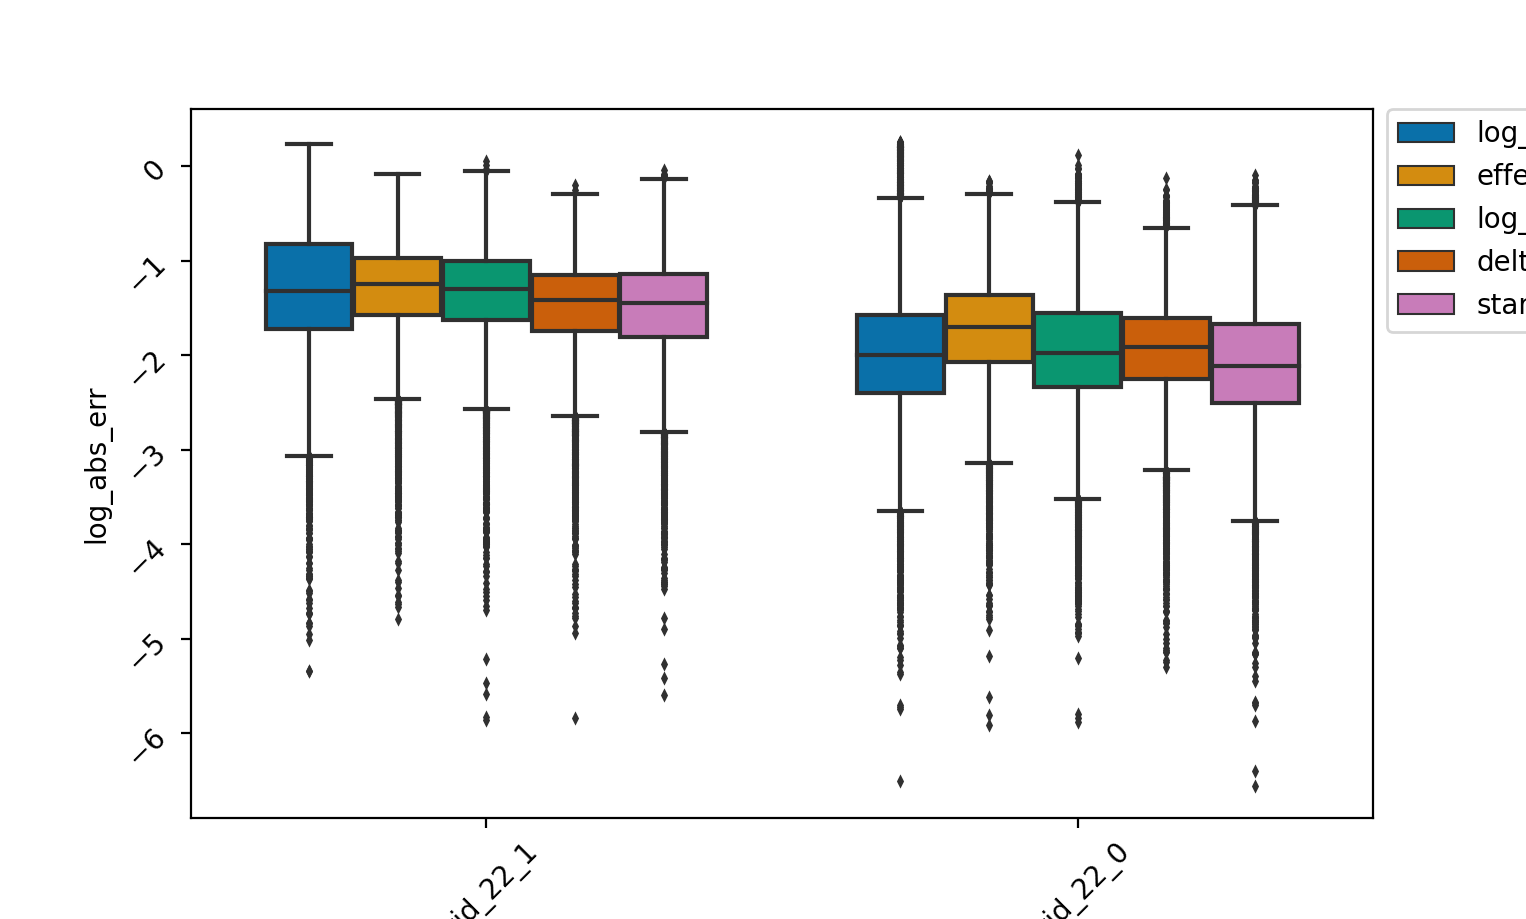

In [145]:
%matplotlib notebook

w = 1.5 * len(grid.data)
fig, ax = plt.subplots(figsize=(w, 4.5))
width = 0.15 * len(y_cols)
sns.boxplot(data=df_err_col, x='name', y='log_abs_err', hue='output',
            width=width, fliersize=2, color='C0', palette='colorblind',
            order=order, ax=ax, saturation=0.9)
# ax.set_yscale('log')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.02))

In [146]:
network = grid.networks[1]

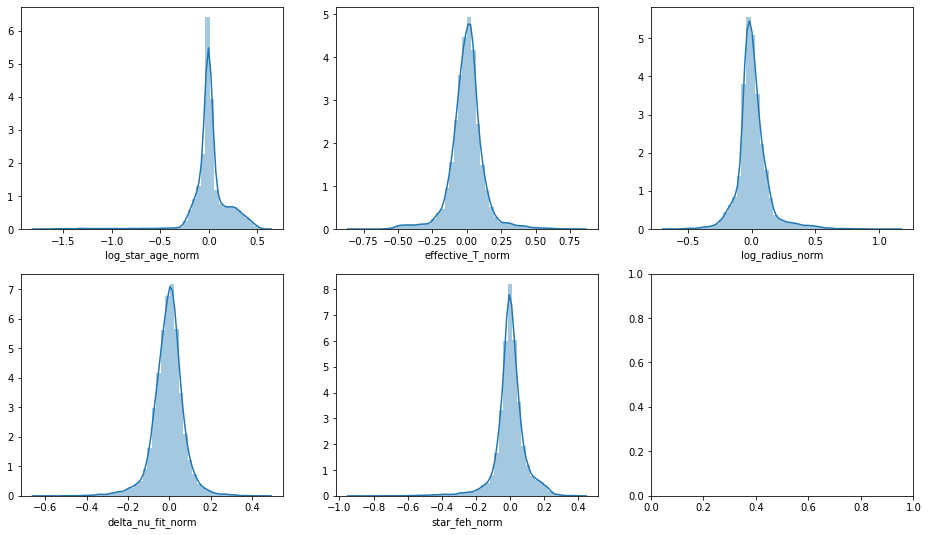

In [147]:
%matplotlib inline

network.plot_metric(val, metric='error', save_plot=False);